In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#make cosmo global so emcee doesnt have to pickle all the data making things faster 
global cosmo

from Cosmo import *

box = 'Box_n50_0_1400'
cosmo = Cosmo(box)
print(cosmo.h)

from utils import set_cosmo
set_cosmo(cosmo)

from utils import *

0.67


In [3]:
import numpy as np
from scipy.stats import binned_statistic
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import os
import emcee
import sys
import numpy as np
import pickle

In [6]:
[cosmo.z_to_a[z] for z in z_cur]

[0.366459,
 0.403224,
 0.488191,
 0.512095,
 0.537169,
 0.563471,
 0.591061,
 0.620002,
 0.65036,
 0.715608,
 0.787402,
 0.866399,
 0.953321,
 1.0]

In [7]:
z_cur = cosmo.get_redshifts()
zlt2 = np.where(z_cur<=2)
z_cur = z_cur[zlt2]
a_cur = np.array([cosmo.z_to_a[z] for z in z_cur])
a_cur = [0.512095]

In [8]:
cosmo.prepare_data(a_cur)

  0%|          | 0/1 [00:00<?, ?it/s]/home/users/delon/aemulusnu_massfunction/Cosmo.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
100%|██████████| 1/1 [00:04<00:00,  4.45s/it]


In [33]:
param_names=['d', 'e', 'f', 'g']


guess = np.random.uniform(high=5,size=(len(param_names)))
while(not np.isfinite(log_likelihood(guess))):
    guess = np.random.uniform(high=5,size=(len(param_names)))

#Start by sampling with a maximum likelihood approach
nll = lambda *args: -log_likelihood(*args)
result = optimize.minimize(nll, guess, method="Nelder-Mead", options={
    'maxiter': 8*10000
})

In [35]:
print(result)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 10362.755877915675
             x: [ 5.161e-02  5.140e-27  2.734e+00  1.485e+00]
           nit: 6060
          nfev: 9878
 final_simplex: (array([[ 5.161e-02,  5.140e-27,  2.734e+00,  1.485e+00],
                       [ 5.161e-02,  5.149e-27,  2.734e+00,  1.485e+00],
                       ...,
                       [ 5.161e-02,  5.143e-27,  2.734e+00,  1.485e+00],
                       [ 5.161e-02,  5.144e-27,  2.734e+00,  1.485e+00]]), array([ 1.036e+04,  1.036e+04,  1.036e+04,  1.036e+04,
                        1.036e+04]))


/tmp/ipykernel_22292/2403056646.py:87: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhline(0, c='black')


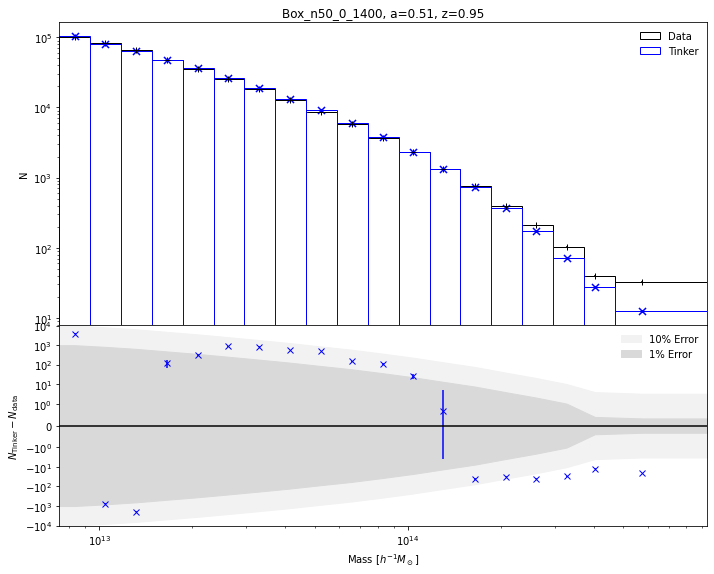

In [34]:
param_values = result['x']
i=0
yerr_dict = {a:np.sqrt(np.diagonal(cosmo.weighted_cov[a])) for a in cosmo.weighted_cov}

for a in reversed(cosmo.N_data.keys()):
    z = cosmo.a_to_z[a]
    fig1 = plt.figure(figsize =(12, 7))
    
    d = param_values[0]
    e = param_values[1]
    f = param_values[2]
    g = param_values[3]
    params_final = dict(zip(['d', 'e', 'f', 'g'], [d,e,f,g]))
    axs=[fig1.add_axes((0.2,0.4,.75,.6)), fig1.add_axes((0.2,0.0,.75,.4))]
    plt.subplots_adjust(wspace=0, hspace=0)
    Pk = cosmo.Pkz[z]
    c_data = cosmo.NvMs[a]

    Ms = cosmo.M_data[a]
    N = cosmo.N_data[a]
    edge_pairs = c_data['edge_pairs']

    edges = [edge[0] for edge in edge_pairs]
    edges += [edge_pairs[-1][1]]

    yerr = yerr_dict[a]
    vol = cosmo.vol
    dM = np.array([edges[1]-edges[0] for edges in edge_pairs])
    dndM = (np.array(N)/vol)/dM
    tinker = cosmo.tinker
    tinker_eval_MCMC = [tinker(a, M_c,**params_final) for M_c in Ms]


    M_numerics = cosmo.M_numerics
    tinker_eval_MCMC = [tinker(a, M_c,**params_final,)*vol for M_c in M_numerics]

    f_dndM_MCMC_LOG = interp1d(np.log10(M_numerics), tinker_eval_MCMC, kind='cubic', bounds_error=False, fill_value=0.)
    f_dndM_MCMC = lambda x:f_dndM_MCMC_LOG(np.log10(x))

    tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, edge[0],  edge[1])[0] for edge in edge_pairs])

    color = plt.colormaps["rainbow"]((i+1)/len(cosmo.Pkz.keys()))[:-1]



    axs[0].errorbar(Ms, N, yerr, fmt='+', c='black')
    axs[0].scatter(Ms, tinker_eval_MCMC, s=50 , marker='x', c='blue')

    edges = np.array(edges)
    tmp = 0# edges[:-1]*10**(0.01)-edges[:-1]
    axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges),
               align='edge', fill=False, ec='black', label='Data')
    axs[0].bar(x=edges[:-1]-tmp, height=tinker_eval_MCMC, width=np.diff(edges), align='edge', fill=False, ec='blue', label='Tinker')
    axs[1].errorbar(Ms, (tinker_eval_MCMC-N), yerr, fmt='x', color='blue')

    y1 = 0.1*np.array(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.1*np.array(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    c_Ms = np.append(Ms, edges[-1])
    c_Ms = np.append(edges[0], c_Ms)
    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.95',label='10% Error')

    y1 = 0.01*np.array(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.01*np.array(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.85',label='1% Error')


    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].legend(frameon=False)
    axs[0].set_ylabel('N')

    axs[1].set_xscale('log')
    axs[1].set_yscale('symlog', linthresh=1)    
    axs[1].legend(frameon=False)
    axs[1].axhline(0, c='black')
    axs[1].set_ylabel('N')
    axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
    axs[1].set_ylabel(r'${N_{\rm Tinker}-N_{\rm data}} $')
    axs[0].set_title('%s, a=%.2f, z=%.2f'%(cosmo.box, a, cosmo.a_to_z[a]))
    i+=1

    axs[0].set_xlim((200*cosmo.Mpart, np.max(edges)))
    axs[1].set_xlim((200*cosmo.Mpart, np.max(edges)))

#     plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/%s_ML+MCMCFits_a%.2f.pdf'%(box, a), bbox_inches='tight')

In [10]:
result, sampler = fit_MCMC(nwalkers = 32, ndim = 4, n_jumps = 5000, result=result)

  0%|          | 0/5000 [00:00<?, ?it/s]/oak/stanford/orgs/kipac/users/delon/miniconda3/envs/massfunction/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [02:58<00:00, 27.97it/s]


In [46]:
chain = cosmo.sampler.get_chain(flat=True, discard=3000)
cov_matrix = np.cov(chain.T)

# compute the eigendecomposition of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# sort the eigenvectors in decreasing order of eigenvalues
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# the eigenvectors form the columns of the orthogonal matrix
cosmo.rotation_matrix = eigenvectors

cosmo.inv_rotation_matrix = cosmo.rotation_matrix.T
print(cov_matrix)
print(cosmo.rotation_matrix @ cov_matrix @ cosmo.rotation_matrix.T) 

[[ 5.67704639e-05 -1.97788744e-05 -1.20520883e-06  1.66511391e-05]
 [-1.97788744e-05  5.62461683e-04 -4.64556602e-06 -3.87091668e-06]
 [-1.20520883e-06 -4.64556602e-06  7.19816888e-08 -3.67102350e-07]
 [ 1.66511391e-05 -3.87091668e-06 -3.67102350e-07  5.16852836e-06]]
[[ 5.19874780e-04  1.12686468e-06 -1.68653351e-05  1.49288020e-04]
 [ 1.12686468e-06  5.63043791e-05  1.59739557e-05 -1.29809897e-06]
 [-1.68653351e-05  1.59739557e-05  5.37683464e-06 -5.30628002e-06]
 [ 1.49288020e-04 -1.29809897e-06 -5.30628002e-06  4.29166626e-05]]


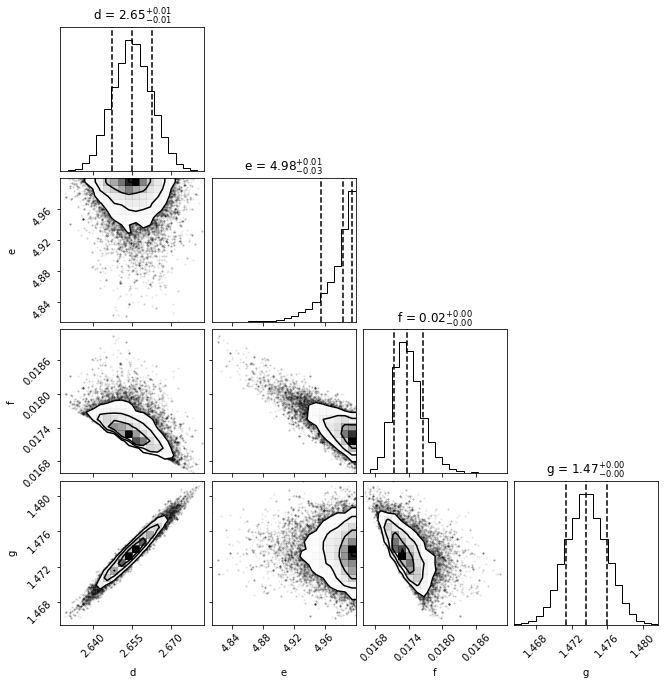

In [37]:
labels=['d', 'e', 'f', 'g']
N_jumps = len(cosmo.sampler.chain[0])
samples = cosmo.sampler.chain[:, N_jumps//5*4:, :].reshape((-1, 4))
fig = corner.corner(samples, labels=labels, quantiles=[0.16, 0.5, 0.84],show_titles=True,)

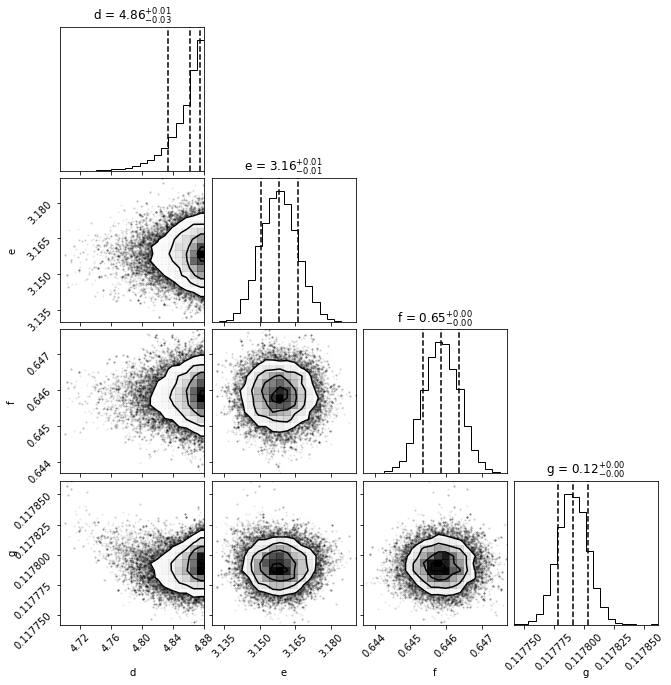

In [38]:
labels=['d', 'e', 'f', 'g']
N_jumps = len(cosmo.sampler.chain[0])
samples = cosmo.sampler.chain[:, N_jumps//5*4:, :].reshape((-1, 4))

chain = sampler.get_chain(flat=True, discard=3500)
rotated_chain = chain @ cosmo.rotation_matrix

fig = corner.corner(rotated_chain, labels=labels, quantiles=[0.16, 0.5, 0.84],show_titles=True,)

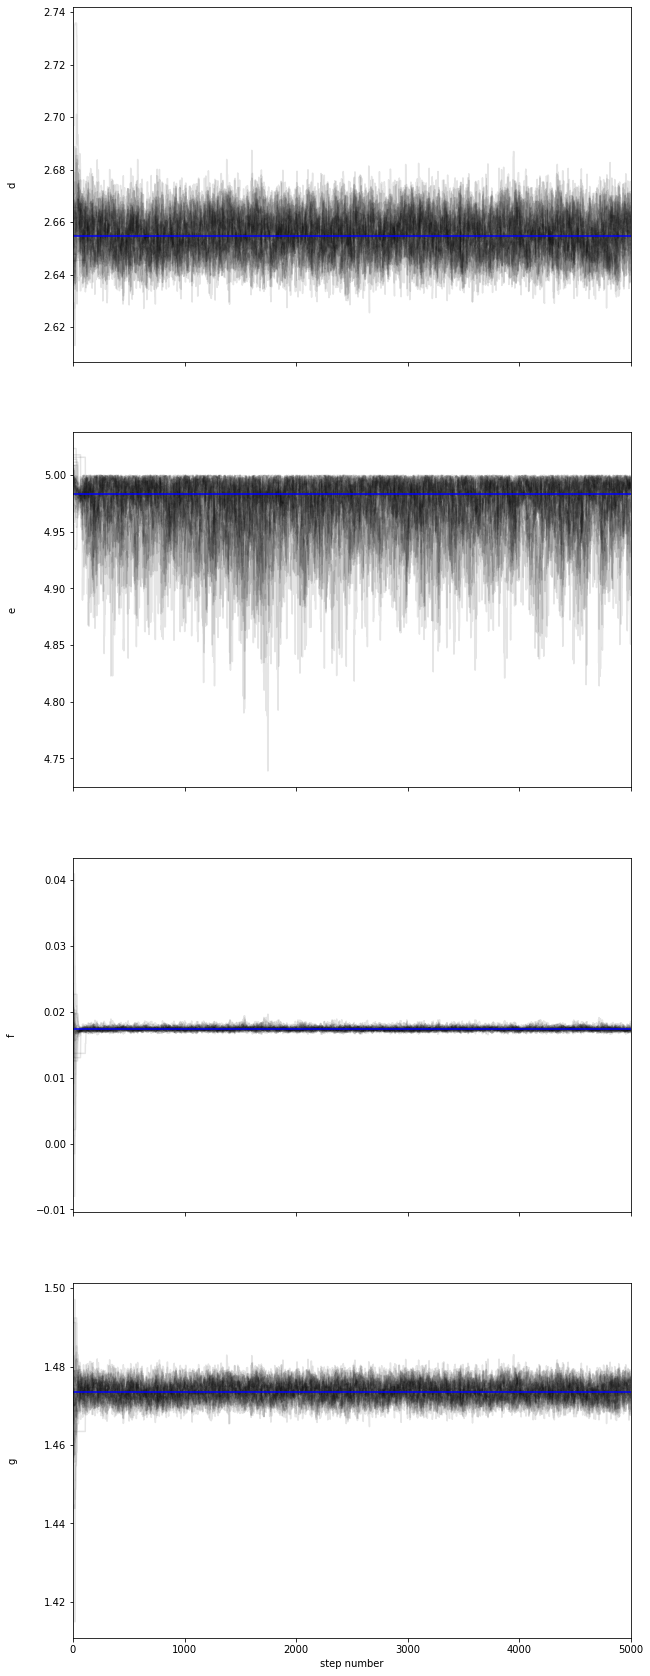

In [39]:
ndim = len(labels)

final_params = cosmo.get_MCMC_params(labels=labels)
final_param_vals = list(final_params.values())

fig, axes = plt.subplots(ndim, figsize=(10, 30), sharex=True)
samples = cosmo.sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
#             ax.axhline(result['x'][i], color='red')
    ax.axhline(final_param_vals[i], color='blue')
axes[-1].set_xlabel("step number");


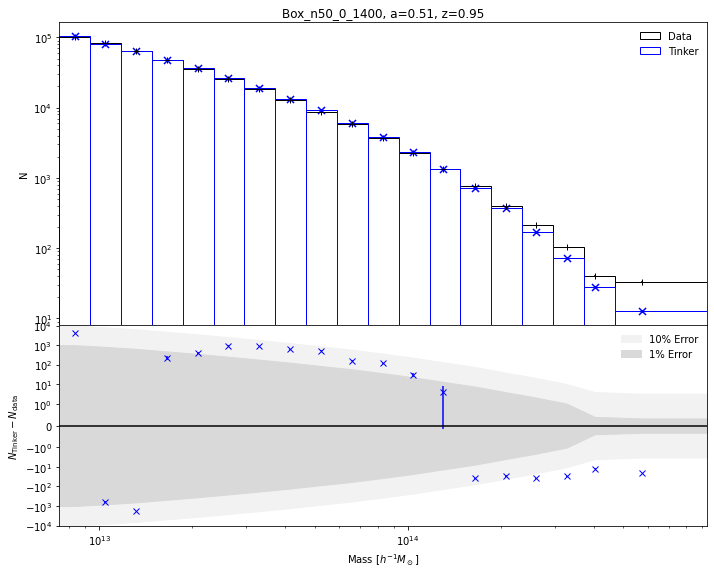

In [40]:
yerr_dict = {a:np.sqrt(np.diagonal(cosmo.weighted_cov[a])) for a in cosmo.weighted_cov}
cosmo.get_mass_function_plots(yerr_dict=yerr_dict, labels=labels)

In [41]:
def log_likelihood_rotated(param_values): 
    param_values_unrotated = np.array([param_values]) @ cosmo.inv_rotation_matrix
    param_values_unrotated = param_values_unrotated[0]
    lp = log_prior(param_values_unrotated)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_prob(param_values_unrotated)

In [42]:
guess = np.random.uniform(size=4)
while(not np.isfinite(log_likelihood_rotated(guess))):
    guess = np.random.uniform(size=4)
print('starting rotated fit')
#Start by sampling with a maximum likelihood approach
nll = lambda *args: -log_likelihood_rotated(*args)
result_rotated = optimize.minimize(nll, guess, method="Nelder-Mead", options={
    'maxiter': 8*10000
})
result_rotated['param_names'] = ['d_rot', 'e_rot', 'f_rot', 'g_rot']

print(result_rotated)

starting rotated fit
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 10505.280806300858
             x: [-3.807e-02  4.330e-01  1.473e+00  2.785e+00]
           nit: 3036
          nfev: 4970
 final_simplex: (array([[-3.807e-02,  4.330e-01,  1.473e+00,  2.785e+00],
                       [-3.807e-02,  4.330e-01,  1.473e+00,  2.785e+00],
                       ...,
                       [-3.807e-02,  4.330e-01,  1.473e+00,  2.785e+00],
                       [-3.807e-02,  4.330e-01,  1.473e+00,  2.785e+00]]), array([ 1.051e+04,  1.051e+04,  1.051e+04,  1.051e+04,
                        1.051e+04]))
   param_names: ['d_rot', 'e_rot', 'f_rot', 'g_rot']


[7.88599029e-02 2.17881269e-15 2.80575345e+00 1.49548212e+00]


/tmp/ipykernel_22292/2468955964.py:89: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhline(0, c='black')


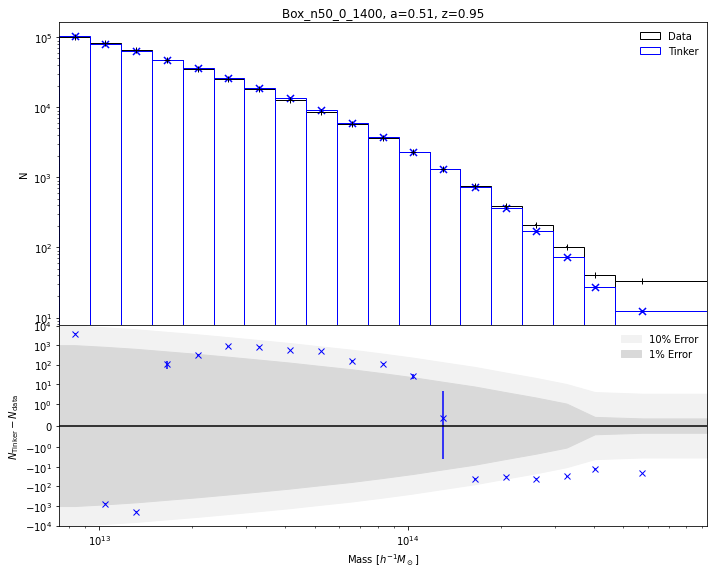

In [43]:
param_values = result_rotated['x']
param_values = np.array(param_values) @ cosmo.inv_rotation_matrix
print(param_values)
i=0
yerr_dict = {a:np.sqrt(np.diagonal(cosmo.weighted_cov[a])) for a in cosmo.weighted_cov}

for a in reversed(cosmo.N_data.keys()):
    z = cosmo.a_to_z[a]
    fig1 = plt.figure(figsize =(12, 7))
    
    d = param_values[0]
    e = param_values[1]
    f = param_values[2]
    g = param_values[3]
    params_final = dict(zip(['d', 'e', 'f', 'g'], [d,e,f,g]))
    axs=[fig1.add_axes((0.2,0.4,.75,.6)), fig1.add_axes((0.2,0.0,.75,.4))]
    plt.subplots_adjust(wspace=0, hspace=0)
    Pk = cosmo.Pkz[z]
    c_data = cosmo.NvMs[a]

    Ms = cosmo.M_data[a]
    N = cosmo.N_data[a]
    edge_pairs = c_data['edge_pairs']

    edges = [edge[0] for edge in edge_pairs]
    edges += [edge_pairs[-1][1]]

    yerr = yerr_dict[a]
    vol = cosmo.vol
    dM = np.array([edges[1]-edges[0] for edges in edge_pairs])
    dndM = (np.array(N)/vol)/dM
    tinker = cosmo.tinker
    tinker_eval_MCMC = [tinker(a, M_c,**params_final) for M_c in Ms]


    M_numerics = cosmo.M_numerics
    tinker_eval_MCMC = [tinker(a, M_c,**params_final,)*vol for M_c in M_numerics]

    f_dndM_MCMC_LOG = interp1d(np.log10(M_numerics), tinker_eval_MCMC, kind='cubic', bounds_error=False, fill_value=0.)
    f_dndM_MCMC = lambda x:f_dndM_MCMC_LOG(np.log10(x))

    tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, edge[0],  edge[1])[0] for edge in edge_pairs])

    color = plt.colormaps["rainbow"]((i+1)/len(cosmo.Pkz.keys()))[:-1]



    axs[0].errorbar(Ms, N, yerr, fmt='+', c='black')
    axs[0].scatter(Ms, tinker_eval_MCMC, s=50 , marker='x', c='blue')

    edges = np.array(edges)
    tmp = 0# edges[:-1]*10**(0.01)-edges[:-1]
    axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges),
               align='edge', fill=False, ec='black', label='Data')
    axs[0].bar(x=edges[:-1]-tmp, height=tinker_eval_MCMC, width=np.diff(edges), align='edge', fill=False, ec='blue', label='Tinker')
    axs[1].errorbar(Ms, (tinker_eval_MCMC-N), yerr, fmt='x', color='blue')

    y1 = 0.1*np.array(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.1*np.array(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    c_Ms = np.append(Ms, edges[-1])
    c_Ms = np.append(edges[0], c_Ms)
    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.95',label='10% Error')

    y1 = 0.01*np.array(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.01*np.array(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.85',label='1% Error')


    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].legend(frameon=False)
    axs[0].set_ylabel('N')

    axs[1].set_xscale('log')
    axs[1].set_yscale('symlog', linthresh=1)    
    axs[1].legend(frameon=False)
    axs[1].axhline(0, c='black')
    axs[1].set_ylabel('N')
    axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
    axs[1].set_ylabel(r'${N_{\rm Tinker}-N_{\rm data}} $')
    axs[0].set_title('%s, a=%.2f, z=%.2f'%(cosmo.box, a, cosmo.a_to_z[a]))
    i+=1

    axs[0].set_xlim((200*cosmo.Mpart, np.max(edges)))
    axs[1].set_xlim((200*cosmo.Mpart, np.max(edges)))

#     plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/%s_ML+MCMCFits_a%.2f.pdf'%(box, a), bbox_inches='tight')

In [44]:
nwalkers = 32
initialpos = np.array([result_rotated['x'] for _ in range(nwalkers)]) + 1e-2 * np.random.normal(size=(nwalkers, 4))
sampler_rotated = emcee.EnsembleSampler(
    nwalkers = nwalkers,
    ndim = 4,
    log_prob_fn = log_likelihood_rotated,
    pool=Pool()
)

sampler_rotated.run_mcmc(initialpos, 4000, progress=True);

100%|██████████| 4000/4000 [02:29<00:00, 26.72it/s]


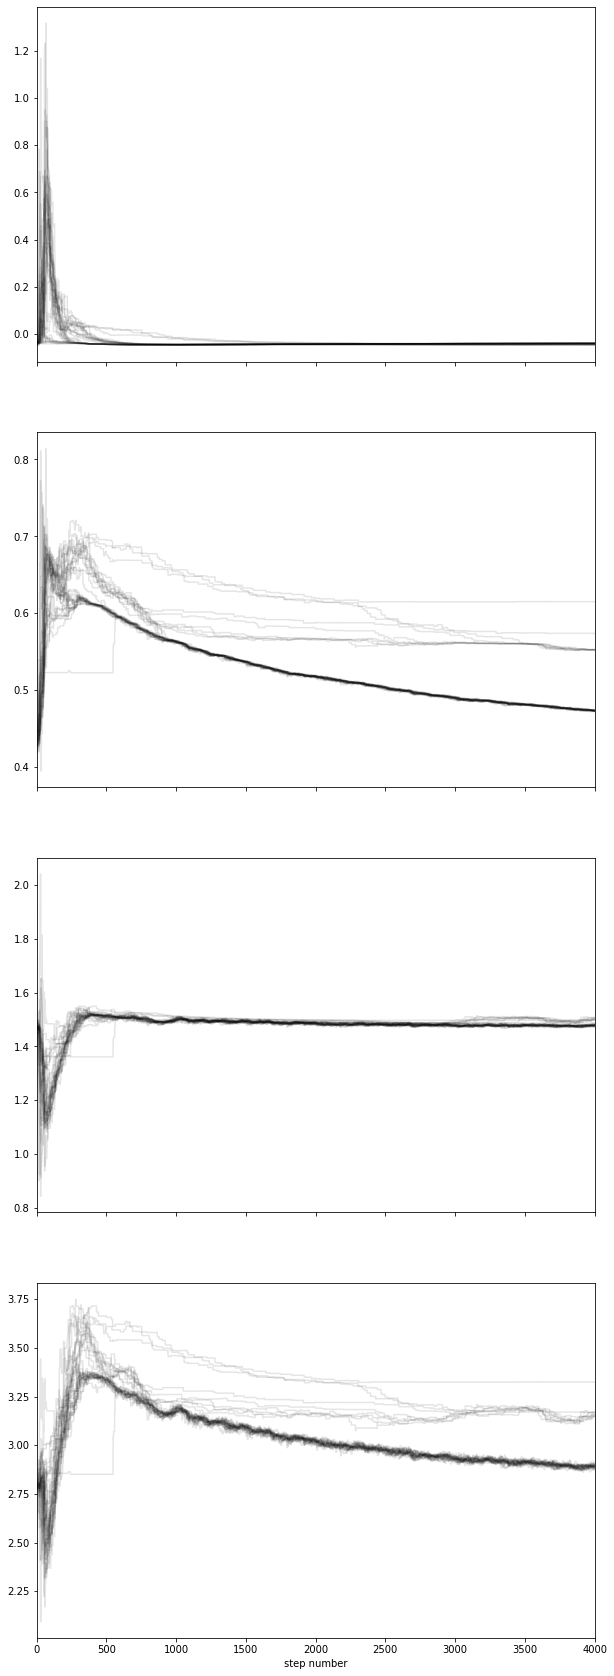

In [45]:
fig, axes = plt.subplots(4, figsize=(10, 30), sharex=True)
samples = sampler_rotated.get_chain()
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(samples))
#     ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
#     ax.axhline(final_param_vals[i], color='blue')
axes[-1].set_xlabel("step number");

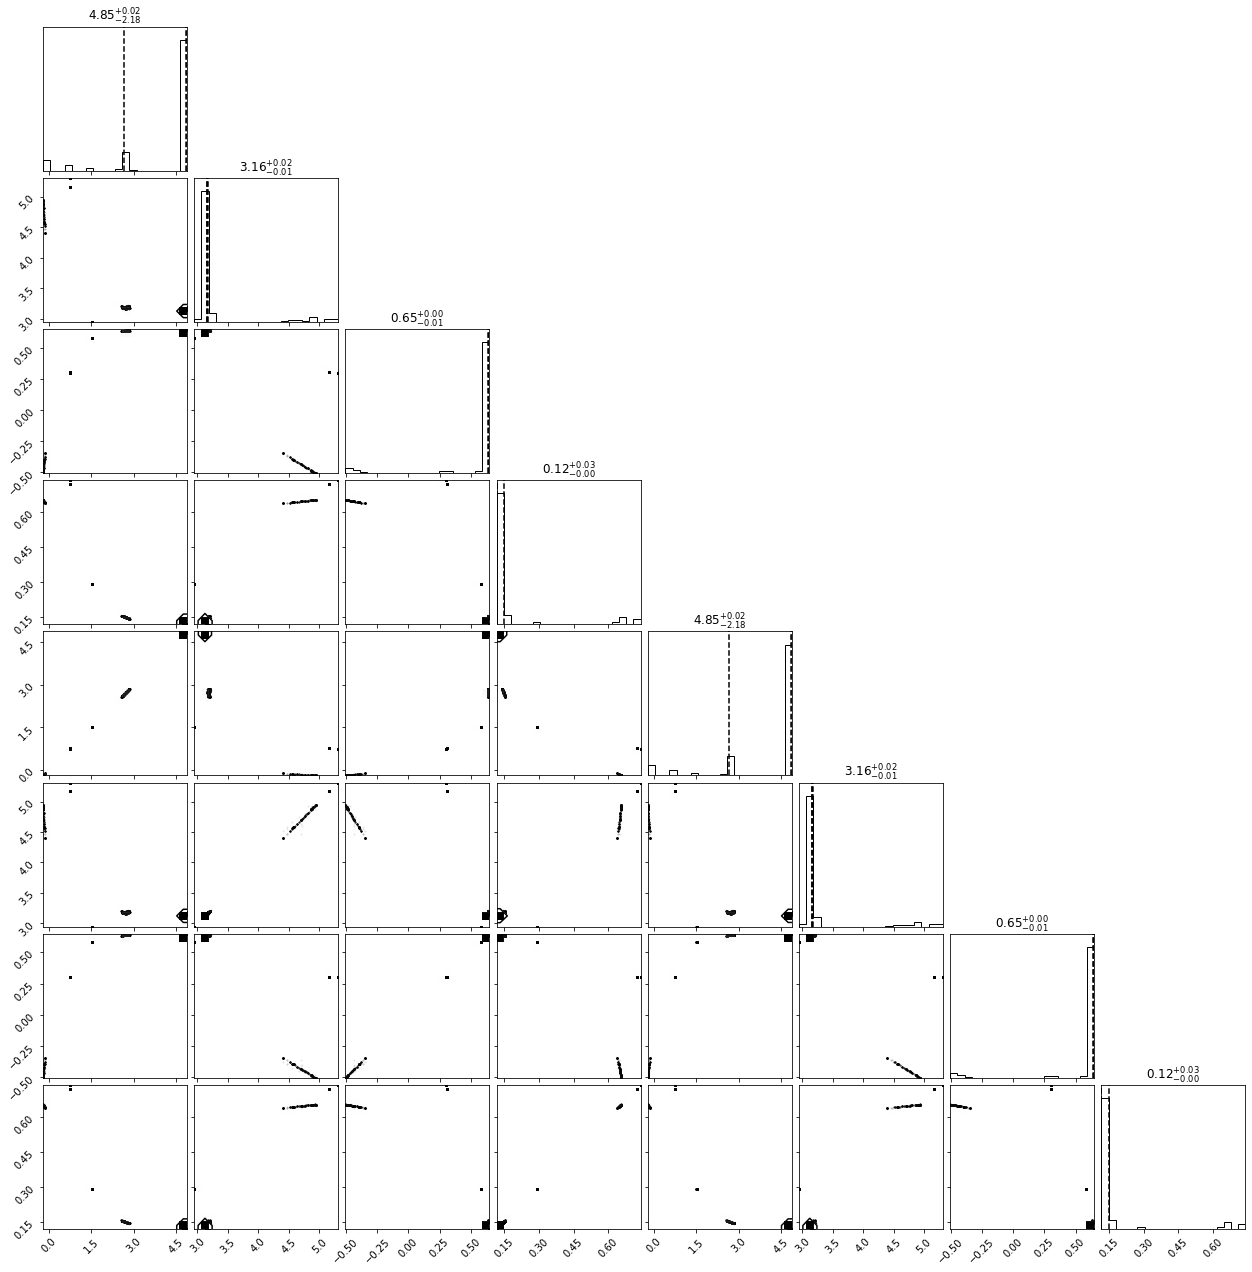

In [28]:
N_jumps = len(sampler_rotated.chain[0])
samples = sampler_rotated.chain[:, 3500:, :].reshape((-1, 8))
fig = corner.corner(samples, quantiles=[0.16, 0.5, 0.84],show_titles=True,)